In [123]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import torch
from torch import nn
import numpy as np
from icecream import ic
from tqdm import tqdm
from get_data import *
from dataloader import *

In [146]:
 #Define the LSTM model class

# Use the GPU if available
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device="cpu"
print(device)

class LSTMmodel(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, layers, window_size=4):

        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.ws = window_size

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, one_full_traj):

        seq = one_full_traj[0:self.ws, :]
        
        lstm_out, hidden = self.lstm(seq)           
        pred = self.linear(lstm_out)

        out = one_full_traj[self.ws-1:self.ws, 1:] + pred[-1: , :]

        for t in range(1, self.ws):
            tmp = torch.cat(( one_full_traj[self.ws+t:self.ws+t+1, 0:1] , out[(t-1):t,:]), dim=1)
            
            seq = torch.cat((one_full_traj[t:self.ws+(t-1), :], tmp), dim=0)
            
            lstm_out, hidden = self.lstm(seq)           
            pred = self.linear(lstm_out)
            out = torch.cat((out, one_full_traj[self.ws+(t-1): self.ws+t, 1:] + pred[-1: , :]))

        for t in range(self.ws, one_full_traj.size(dim=0) - self.ws):
            seq = torch.cat((out[t - self.ws : t , :], one_full_traj[t : t + self.ws, 0:1]), dim=1)
            
            lstm_out, hidden = self.lstm(seq)           
            pred = self.linear(lstm_out)

            out = torch.cat((out, out[t-1:t, :] + pred[-1: , :]))


        return out, hidden          
    

        #works
        #Without Resnet connection at the end
        
    #    def forward(self, one_full_traj):

        # seq = one_full_traj[0:self.ws, :]
        
        # lstm_out, hidden = self.lstm(seq)           
        # pred = self.linear(lstm_out)

        # out = pred[-1: , :]

        # for t in range(1, self.ws):
        #     tmp = torch.cat(( one_full_traj[self.ws+t:self.ws+t+1, 0:1] , out[(t-1):t,:]), dim=1)
            
        #     seq = torch.cat((one_full_traj[t:self.ws+(t-1), :], tmp), dim=0)
            
        #     lstm_out, hidden = self.lstm(seq)           
        #     pred = self.linear(lstm_out)
        #     out = torch.cat((out, pred[-1:,:]))

        # for t in range(self.ws, one_full_traj.size(dim=0) - self.ws):

        #     seq = torch.cat((out[t - self.ws : t , :], one_full_traj[t : t + self.ws, 0:1]), dim=1)
            
        #     lstm_out, hidden = self.lstm(seq)           
        #     pred = self.linear(lstm_out)
        #     out = torch.cat((out, pred[-1:,:]))

        # return out, hidden          





cpu


In [ ]:
def test(test_data, model, steps=600, ws=10, plot_opt=False, n = 5, rand=True):

    #test_data = test_dataloader.get_all_data() 
    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0
    
    if rand:
     np.random.seed(1234)
 
    ids = np.random.choice(test_data.size(dim=0), min([n, test_data.size(dim=0)]), replace=False)
    ids = np.unique(ids)


    for i, x in enumerate(test_data):
        x=x.to(device)
        if i not in ids:
            continue

        with torch.inference_mode():

            pred = torch.zeros((steps, 3), device=device)

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]

            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]

            #for i in range(len(x) - ws):

                # out, _ = model(pred[i:i+ws, :])
                # pred[i+ws, :] = pred[i+ws-1, :] + out[-1, :]
                # pred_next_step[i+ws, :] = x[i+ws-1, :] + out[-1, :]
            
            out, _ = model(x)
            pred[ws:,1:] = out
            
            test_loss += loss_fn(pred[ws:, 1], x[ws:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[ws:, 2], x[ws:, 2]).detach().cpu().numpy()
            total_loss += loss_fn(pred[ws:, 1:], x[ws:, 1:]).detach().cpu().numpy()

            if plot_opt:
                figure , axs = plt.subplots(1,3,figsize=(16,9))
            
                axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
                axs[0].plot(x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
                axs[0].set_title("position")
                axs[0].grid()
                axs[0].legend()

                axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
                axs[1].plot(x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
                axs[1].set_title("speed")
                axs[1].grid()
                axs[1].legend()

                axs[2].plot(x.detach().cpu().numpy()[:,0], label="pressure")
                axs[2].set_title("pressure")
                axs[2].grid()
                axs[2].legend()

                plt.grid(True)
                plt.legend()
                plt.show()
            
    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss)


In [135]:
#with future:

def train(input_data, model, weight_decay, learning_rate=0.001, ws=0, batch_size=5):

    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

    model.train()
    total_loss = []

    loss_batch = 0

    for k, x in enumerate(input_data):  # inp = (u, x) label = x
        
        output, _ = model(x)

        # out = []

        # for i in range(future):
        #     out.append(inp[:, :, :] + output[i])

        # reset the gradient
        optimizer.zero_grad(set_to_none=True)
        # calculate the error
        loss = loss_fn(output, x[ws:, 1:])
        loss_batch += loss
        
        #loss.backward(retain_graph=True)
        if k % batch_size==0:
            #print("grad update after ", k, "trajetories")
            loss_batch.backward()
            optimizer.step()
            loss_batch = 0

        total_loss.append(loss.detach().cpu().numpy())

   # return the average error of the next step prediction
    return np.mean(total_loss)


In [144]:

# set some parameters for learning 
                    #window_size, h_size,  l_num,  epochs, learning_rate,  part_of_data,   weight_decay,   percentage_of_data   batch_size
parameter_sets  =    [4,             6 ,      1,       20,       0.001,          30,           1e-5,               0.1,             5]
           # {'lr': 0.0006226762071294569, 'ws': 9, 'bs': 51, 'hs': 13, 'ls': 2}         
window_size, h_size,  l_num,  epochs, learning_rate,  part_of_data,   weight_decay,   percentage_of_data ,  batch_size = parameter_sets

# Initialize the LSTM model
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num, window_size=window_size).to(device)
#model = RNNmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)

# Generate input data (the data is normalized and some timesteps are cut off)
input_data = get_data(path = "save_data_test4.csv", 
                        timesteps_from_data=0, 
                        skip_steps_start = 0,
                        skip_steps_end = 0, 
                        drop_half_timesteps = True,
                        normalise_s_w="minmax",
                        rescale_p=False,
                        num_inits=part_of_data)

cut_off_timesteps = 0

#Split data into train and test sets
np.random.seed(1234)
num_of_inits_train = int(len(input_data)*percentage_of_data)
train_inits = np.random.choice(np.arange(len(input_data)),num_of_inits_train,replace=False)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

train_data = input_data[train_inits,:input_data.size(dim=1)-cut_off_timesteps,:]
test_data = input_data[test_inits,:,:]

losses = []
average_traj_err_train = []
average_traj_err_test = []

for e in tqdm(range(epochs)):
    
    loss_epoch = train(train_data, model, weight_decay, learning_rate=learning_rate, ws=window_size, batch_size=batch_size)
    losses.append(loss_epoch)

    # Every few epochs get the error MSE of the true data
    # compared to the network prediction starting from some initial conditions
    if (e+1)%3 == 0:

        _,_, err_train = test(train_data, model, steps=train_data.size(dim=1), ws=window_size, plot_opt=False, n = 20)
        # if err_train < 0.05:
        #     print("stopped early")
        #     break
        #_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 20)
        average_traj_err_train.append(err_train)
        #average_traj_err_test.append(err_test)
        print(f"Epoch: {e}, the average next step error was : loss_epoch")
        print(f"Average error over full trajectories: training data : {err_train}")
        #print(f"Average error over full trajectories: testing data : {err_test}")

_,_, err_train = test(train_data, model, steps=train_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
#_,_, err_test = test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=False, n = 100)
print(f"TRAINING FINISHED: Average error over full trajectories: training data : {err_train}")
#print(f"TRAINING FINISHED: Average error over full trajectories: testing data : {err_test}")
        

 15%|█▌        | 3/20 [00:04<00:25,  1.50s/it]

Epoch: 2, the average next step error was : loss_epoch
Average error over full trajectories: training data : 15969.825646614556


 30%|███       | 6/20 [00:08<00:20,  1.50s/it]

Epoch: 5, the average next step error was : loss_epoch
Average error over full trajectories: training data : 14762.920311361959


 45%|████▌     | 9/20 [00:13<00:16,  1.47s/it]

Epoch: 8, the average next step error was : loss_epoch
Average error over full trajectories: training data : 13592.575829763075


 60%|██████    | 12/20 [00:17<00:11,  1.50s/it]

Epoch: 11, the average next step error was : loss_epoch
Average error over full trajectories: training data : 12452.756269463878


 75%|███████▌  | 15/20 [00:21<00:07,  1.54s/it]

Epoch: 14, the average next step error was : loss_epoch
Average error over full trajectories: training data : 11337.906573497352


 90%|█████████ | 18/20 [00:26<00:03,  1.51s/it]

Epoch: 17, the average next step error was : loss_epoch
Average error over full trajectories: training data : 10241.379128527984


100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


TRAINING FINISHED: Average error over full trajectories: training data : 9516.73527888814


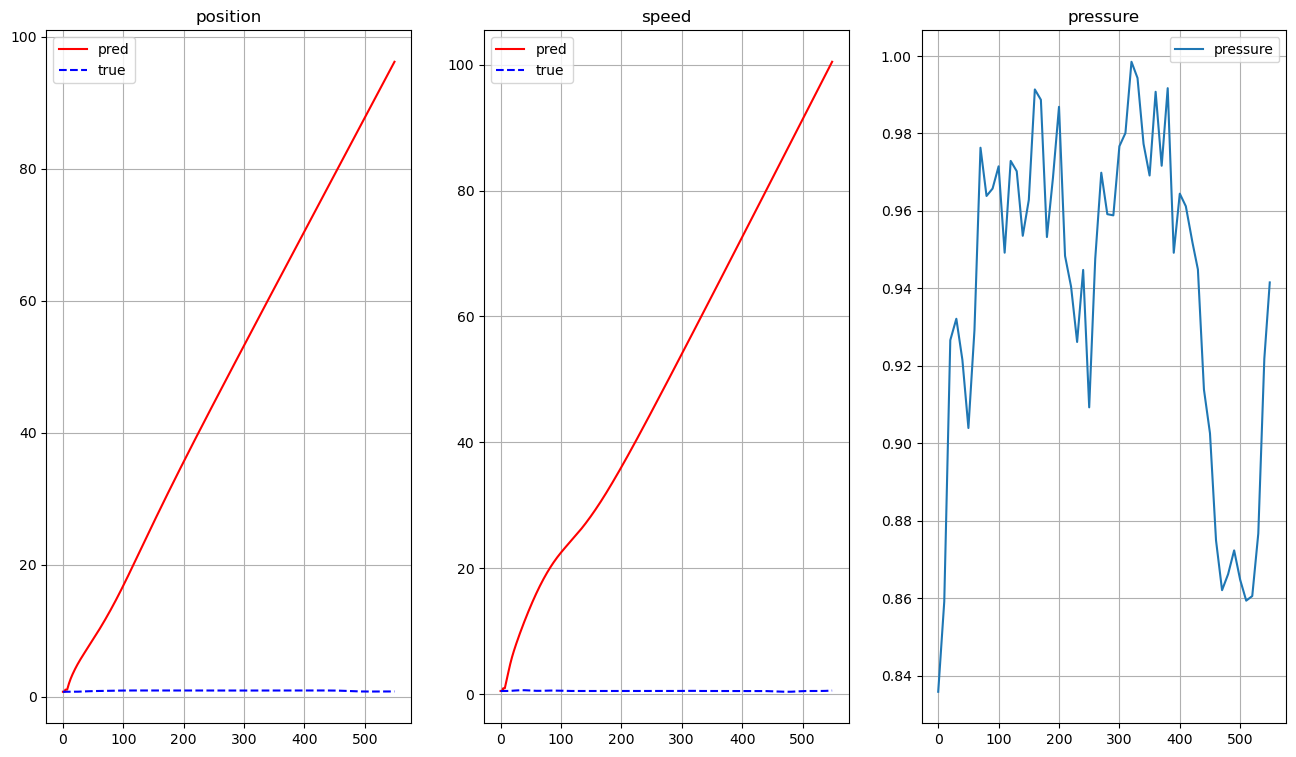

(3055.9035714735437, 3327.5455250757086, 3191.724548274626)

In [145]:
#test(test_data, model, steps=test_data.size(dim=1), ws=window_size, plot_opt=True, n = 1, rand=False)
test(train_data, model, steps=train_data.size(dim=1), ws=window_size, plot_opt=True, n = 1, rand=False)

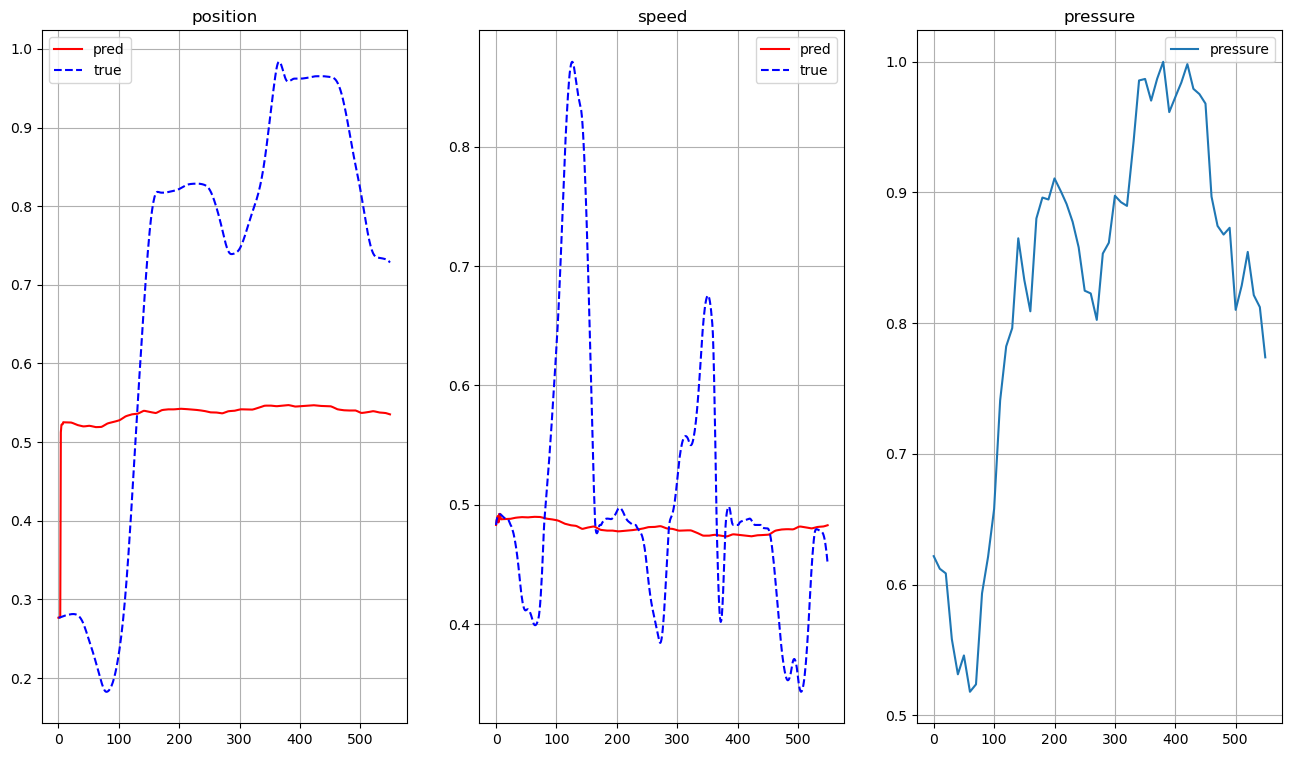

In [122]:
# Save the model
path = f"Ventil_trained_NNs\my_example_model.pth"
torch.save(model.state_dict(), path)

# Load the model and test it on the test data

path = "Ventil_trained_NNs\my_example_model.pth"
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num, window_size=window_size).to(device)
#model = RNNmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

train_data = input_data[train_inits,:,:]

test_loss, test_loss_deriv, total_loss = test(test_data, model, steps=input_data.size(dim=1), ws=window_size, plot_opt=True , n = 1, rand=False)
#test_loss, test_loss_deriv, total_loss = test(train_data, model, steps=input_data.size(dim=1), ws=window_size, plot_opt=True , n = 1, rand=False)
